In [21]:
import TurbPy as tb
from TurbPy.imports import *

In [22]:
# deck = 'KH_Lv1di/'
# deck = 'KH/'
# deck = 'KH_subash/'
# deck = 'KH_400ppc/'
# deck = 'KH_800ppc/'
# deck = 'KH_new/'
# deck = 'turb2/'
# deck = 'turb_vth0.01/'
# deck = 'KH_400ppc_200wci2/'
# deck = 'KH_400ppc_500int/'
deck = 'KH_200ppc_200wci/'

dirs = '/pscratch/sd/g/goodwill/' + deck

figs = '/pscratch/sd/g/goodwill/Fig/' + deck

info = tb.get_vpic_info(dirs)
times = tb.get_times(dirs)

en_out = tb.read_energies(dirs) /(info['Lx/de'] * info['Ly/de'] * info['Lz/de'])
twci_out = np.linspace(0, times[-1] * info['dt*wci'], len(en_out['EM']))
twci = np.linspace(0, times[-1] * info['dt*wci'], len(times))

lx = info['Lx/di']
ly = info['Ly/di']
nx = int(info['nx'])
ny = int(info['ny'])

In [23]:
from TurbPy.vpic_info import *
from TurbPy.load_vars import *
import numpy as np
import pandas as pd

def en_calc(dirs, filt = True,  save = True):
  vpic_info = get_vpic_info(dirs)
  times = get_times(dirs)
  en = {}
  
  E_fe = np.zeros(len(times))
  E_the = np.zeros(len(times))
  E_fi = np.zeros(len(times))
  E_thi = np.zeros(len(times))
  E_m = np.zeros(len(times))
  E_e = np.zeros(len(times))

  for t in np.arange(len(times)):
    dx = vpic_info['dx/de']
    dy = vpic_info['dy/de']
    dz = vpic_info['dz/de']

    if filt == False:
      ds = load_hydro(dirs,times[t], 'ion')
      f = load_fields(dirs,times[t])
      E_m[t] = (1/2) * np.sum(f['cbx']**2 + f['cby']**2 + f['cbz']**2) * dx * dy *dz
      E_e[t] = (1/2) * np.sum(f['ex']**2 + f['ey']**2 + f['ez']**2) * dx * dy * dz

      particle_mass = int(vpic_info['mi/me'])
      ux=ds['jx']/ds['rho']
      uy=ds['jy']/ds['rho']
      uz=ds['jz']/ds['rho']

      pxx = np.array(ds['txx'] - (ux)*ds['px'])
      pyy = np.array(ds['tyy'] - (uy)*ds['py'])
      pzz = np.array(ds['tzz'] - (uz)*ds['pz'])
      # ux=ds['px']/np.abs(ds['rho'])/particle_mass
      # uy=ds['py']/np.abs(ds['rho'])/particle_mass
      # uz=ds['pz']/np.abs(ds['rho'])/particle_mass

      E_thi[t] = (1/2) * np.sum(pxx + pyy + pzz) * dx * dy * dz
      E_fi[t]  = (1/2) * particle_mass  * np.sum( np.abs(ds['rho']) * (ux**2 + uy**2 + uz**2)) * dx * dy * dz

      ds = load_hydro(dirs,times[t], 'electron')
      particle_mass = 1
      ux=ds['jx']/ds['rho']
      uy=ds['jy']/ds['rho']
      uz=ds['jz']/ds['rho']

      pxx = np.array(ds['txx'] - (ux)*ds['px'])
      pyy = np.array(ds['tyy'] - (uy)*ds['py'])
      pzz = np.array(ds['tzz'] - (uz)*ds['pz'])
      # ux=ds['px']/np.abs(ds['rho'])/particle_mass
      # uy=ds['py']/np.abs(ds['rho'])/particle_mass
      # uz=ds['pz']/np.abs(ds['rho'])/particle_mass

      E_the[t] = (1/2) * np.sum(pxx + pyy + pzz) * dx * dy * dz
      E_fe[t]  = (1/2) * particle_mass  * np.sum( np.abs(ds['rho']) * (ux**2 + uy**2 + uz**2)) * dx * dy * dz
    if filt == True:
      ds = load_hydro_fil(dirs,times[t], 'ion')
      f = load_field_fil(dirs,times[t])
      E_m[t] = (1/2) * np.sum(f['cbx']**2 + f['cby']**2 + f['cbz']**2) * dx * dy *dz
      E_e[t] = (1/2) * np.sum(f['ex']**2 + f['ey']**2 + f['ez']**2) * dx * dy * dz

      particle_mass = int(vpic_info['mi/me'])
      ux=ds['jx']/ds['rho']
      uy=ds['jy']/ds['rho']
      uz=ds['jz']/ds['rho']

      pxx = np.array(ds['txx'] - (ux)*ds['px'])
      pyy = np.array(ds['tyy'] - (uy)*ds['py'])
      pzz = np.array(ds['tzz'] - (uz)*ds['pz'])
      # ux=ds['px']/np.abs(ds['rho'])/particle_mass
      # uy=ds['py']/np.abs(ds['rho'])/particle_mass
      # uz=ds['pz']/np.abs(ds['rho'])/particle_mass

      E_thi[t] = (1/2) * np.sum(pxx + pyy + pzz) * dx * dy * dz
      E_fi[t]  = (1/2) * particle_mass  * np.sum( np.abs(ds['rho']) * (ux**2 + uy**2 + uz**2)) * dx * dy * dz

      ds = load_hydro_fil(dirs,times[t], 'electron')
      particle_mass = 1

      ux=ds['jx']/ds['rho']
      uy=ds['jy']/ds['rho']
      uz=ds['jz']/ds['rho']

      pxx = np.array(ds['txx'] - (ux)*ds['px'])
      pyy = np.array(ds['tyy'] - (uy)*ds['py'])
      pzz = np.array(ds['tzz'] - (uz)*ds['pz'])
      

      # ux=ds['px']/np.abs(ds['rho'])/particle_mass
      # uy=ds['py']/np.abs(ds['rho'])/particle_mass
      # uz=ds['pz']/np.abs(ds['rho'])/particle_mass

      E_the[t] = (1/2) * np.sum(pxx + pyy + pzz) * dx * dy * dz
      E_fe[t]  = (1/2) * particle_mass  * np.sum( np.abs(ds['rho']) * (ux**2 + uy**2 + uz**2)) * dx * dy * dz

  en['EM'] = E_m
  en['EE'] = E_e
  en['Ethi'] = E_thi
  en['Efi'] = E_fi
  en['Ethe'] = E_the
  en['Efe'] = E_fe
  en['Et'] = E_m + E_e + E_thi + E_fi + E_the + E_fe
  if save == True:
    if filt == True:
      pd.DataFrame(en).to_csv(dirs + 'en_calc_fil.csv', sep = ',')
    else:
      pd.DataFrame(en).to_csv(dirs + 'en_calc.csv', sep = ',')
  return pd.DataFrame(en)

In [24]:
# en = en_calc(dirs, filt = False)/(info['Lx/de'] * info['Ly/de'] * info['Lz/de'])
# en_fil = en_calc(dirs, filt = True)/(info['Lx/de'] * info['Ly/de'] * info['Lz/de'])
en = tb.read_calc_energies(dirs)/(info['Lx/de'] * info['Ly/de'] * info['Lz/de'])

In [25]:
print(en)

            EE        EM      Ethi       Efi        Ei      Ethe       Efe  \
0     0.000065  0.125000  0.018721  0.026219  0.044940  0.018154  0.000286   
1     0.000073  0.125002  0.018725  0.026185  0.044910  0.018145  0.000314   
2     0.000075  0.125003  0.018734  0.026199  0.044934  0.018144  0.000289   
3     0.000075  0.125005  0.018748  0.026166  0.044914  0.018142  0.000308   
4     0.000079  0.125007  0.018766  0.026155  0.044922  0.018141  0.000297   
...        ...       ...       ...       ...       ...       ...       ...   
1120  0.000124  0.126371  0.020606  0.018298  0.038904  0.023225  0.000393   
1121  0.000124  0.126373  0.020608  0.018288  0.038896  0.023231  0.000395   
1122  0.000124  0.126375  0.020610  0.018279  0.038889  0.023236  0.000395   
1123  0.000124  0.126377  0.020612  0.018270  0.038881  0.023242  0.000396   
1124  0.000124  0.126378  0.020613  0.018261  0.038874  0.023247  0.000397   

            Ee        Et  
0     0.018440  0.188445  
1     0.0

In [26]:



# dEM_fil = en_fil['EM'] - en_fil['EM'][0]
# dEE_fil = en_fil['EE'] - en_fil['EE'][0]

In [27]:
# plt.plot(dEM + dEE)
# plt.plot(dEM_fil + dEE_fil)

In [28]:
dEM_out = (en_out['EM'] + en_out['EE']) - (en_out['EM'][0] + en_out['EE'][0])
dEE_out = en_out['EE'] - en_out['EE'][0]

dEi_out = en_out['Ei'] - en_out['Ei'][0]

dEe_out = en_out['Ee'] - en_out['Ee'][0]

dEt_out = en_out['Et'] - en_out['Et'][0]
print(en_out)

            EE        EM        Ei        Ee        Et
0     0.000065  0.125000  0.044971  0.018726  0.188762
1     0.000076  0.125001  0.044956  0.018729  0.188762
2     0.000076  0.125001  0.044950  0.018736  0.188762
3     0.000068  0.125001  0.044961  0.018732  0.188762
4     0.000070  0.125001  0.044949  0.018741  0.188762
...        ...       ...       ...       ...       ...
5617  0.000124  0.126377  0.038901  0.024112  0.189514
5618  0.000124  0.126378  0.038900  0.024113  0.189514
5619  0.000124  0.126378  0.038899  0.024114  0.189514
5620  0.000124  0.126378  0.038897  0.024115  0.189515
5621  0.000124  0.126379  0.038895  0.024117  0.189515

[5622 rows x 5 columns]


In [29]:
# fig, axs = plt.subplots(4,1, figsize=(15, 10), sharex = True, layout='constrained')
# axs[0].scatter(twci, dEM + dEE, color = 'orange', marker = 'x' , label = r'$E_m (calc)$')
# axs[0].plot(twci_out, dEM_out , label = r'$E_m (out)$')

# axs[1].scatter(twci, dEE, color = 'orange', marker = 'x', label = r'$E_E (calc)$')
# axs[1].plot(twci_out, dEE_out, label = r'$E_E (out)$')

# axs[2].scatter(twci, dEi, color = 'orange', marker = 'x' , label = r'$E_i (calc)$')
# axs[2].scatter(twci, dEfi, color = 'green', marker = 'x' , label = r'$E^{f}_i (calc)$')
# axs[2].scatter(twci, dEthi, color = 'red', marker = 'x' , label = r'$E^{th}_i (calc)$')
# axs[2].plot(twci_out, dEi_out , label = r'$E_i (out)$')

# axs[3].scatter(twci, dEe, color = 'orange', marker = 'x', label = r'$E_e (calc)$')
# axs[3].scatter(twci, dEfe, color = 'green', marker = 'x' , label = r'$E^{f}_e (calc)$')
# axs[3].scatter(twci, dEthe, color = 'red', marker = 'x' , label = r'$E^{th}_e (calc)$')
# axs[3].plot(twci_out, dEe_out, label = r'$E_i (out)$')

# axs[0].ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
# axs[1].ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
# axs[2].ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
# axs[3].ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))

# axs[3].set_xlabel(r'$t \omega_{ci}$')

# axs[0].legend(loc = 'upper right')
# axs[1].legend(loc = 'upper right')
# axs[2].legend(loc = 'upper right')
# axs[3].legend(loc = 'upper right')

# axs[0].grid()
# axs[1].grid()
# axs[2].grid()
# axs[3].grid()

# fig.supylabel(r'$E \left[ \frac{m_e c^2}{d_e^3} \right] $', size = 15)
# fig.supxlabel(r'$ t \omega_{ci} \left[ \frac{e B_0}{m_i c} \right]$', size = 20)

# plt.savefig(figs + 'dE_split.jpg', dpi = 400)

In [30]:
# fig, axs = plt.subplots(1,1, figsize=(15, 10), sharex = True, layout='constrained')
# axs.plot(twci_out, dEM_out + dEE_out, color = 'darkorange' , label = r'$\delta E_M$')
# # axs.plot(twci_out, dEM_out , color = 'aqua', label = r'$E_m (out)$')

# # axs.scatter(twci, dEE, color = 'orange', marker = 'x', label = r'$E_E (calc)$')
# # axs.plot(twci_out, dEE_out, label = r'$E_E (out)$')

# axs.plot(twci, dEi,     color = 'darkorchid', label = r'$\delta E_i$')
# axs.plot(twci, dEfi, color = 'purple' , linestyle = '--', label = r'$\delta E^{f}_i$')
# axs.plot(twci, dEthi,color = 'magenta', linestyle = '--', label = r'$\delta E^{th}_i$')
# # axs.plot(twci_out, dEi_out , label = r'$E_i (out)$')

# axs.plot(twci, dEe,   color = 'darkgreen', label = r'$\delta E_e$')
# axs.plot(twci, dEfe,  color = 'limegreen',linestyle = '--', label = r'$\delta E^{f}_e$')
# axs.plot(twci, dEthe, color = 'lime',linestyle = '--', label = r'$\delta E^{th}_e$')
# axs.plot(twci, dEt, color = 'gray', linestyle = '--', label = r'$\delta E_T$')
# # axs.plot(twci_out, dEe_out, label = r'$E_i (out)$')

# axs.ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
# axs.ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
# axs.ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
# axs.ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))

# axs.legend(loc = 'upper left', fontsize = 16)

# axs.xaxis.set_minor_locator(AutoMinorLocator())
# axs.yaxis.set_minor_locator(AutoMinorLocator())

# axs.tick_params(which='both', width=2, labelsize = 20, right = True, direction = 'in')
# axs.tick_params(which='major', length=10, top = True, right =True)
# axs.tick_params(which='minor', length=5 , top = True, right =True)

# axs.grid()
# # axs.set_ylim(-4.5 * 10**(-3), 3.2 * 10**(-3))
# fig.supylabel(r'$\delta E \left[ \frac{m_e c^2}{d_e^3} \right] $', size = 25)
# fig.supxlabel(r'$ t \omega_{ci}$', size = 25)

# plt.savefig(figs + 'dE.png', dpi = 400)

In [45]:
# ### Read ###

n = 50
time_twci = int(np.round(twci[n],0))
print(time_twci)
dt = info['dt*wpe'] * info['fields_interval']
EM = tb.read_JE(dirs)
# JE_int = -np.cumsum(EM['JE'][n:] * dt)
JE_int = -sci.integrate.cumulative_simpson(EM['JE'][n:] * dt, initial = 0)
JiE_int = -sci.integrate.cumulative_simpson(EM['JiE'][n:] * dt, initial = 0)
JeE_int = -sci.integrate.cumulative_simpson(EM['JeE'][n:] * dt, initial = 0)

sp = 'electron'
dse = pd.read_csv(dirs + f'ps{sp[0]}_av.csv', delimiter = ',')
pse_av = dse[f'PS{sp[0]}'][n:]
# pse_int = np.cumsum(pse_av * dt)
pse_int = sci.integrate.cumulative_simpson(pse_av * dt, initial = 0)
pse_JeE = sci.integrate.cumulative_simpson((-pse_av + EM['JeE'][n:]) * dt, initial = 0)

sp = 'ion'
dsi = pd.read_csv(dirs + f'ps{sp[0]}_av.csv', delimiter = ',')
psi_av = dsi[f'PS{sp[0]}'][n:]
# psi_int = np.cumsum(psi_av * dt)
psi_int = sci.integrate.cumulative_simpson(psi_av * dt, initial = 0)
psi_JiE = sci.integrate.cumulative_simpson((-psi_av - EM['JiE'][n:]) * dt, initial = 0)

dEM = en['EM'] - en['EM'][n]
dEE = en['EE'] - en['EE'][n]

dEi = (en['Efi']  + en['Ethi']) - (en['Efi'] + en['Ethi'])[n]
dEthi = en['Ethi'] - en['Ethi'][n]
dEfi = en['Efi'] - en['Efi'][n]

dEe = (en['Efe'] + en['Ethe']) - (en['Efe'] + en['Ethe'])[n]
dEthe = en['Ethe'] - en['Ethe'][n]
dEfe = en['Efe'] - en['Efe'][n]

dEt = en['Et'] - en['Et'][n]

7


In [46]:
# fig, ax = plt.subplots(1,1, figsize=(15, 10), sharex = True, layout='constrained')
# ax.plot(twci[n:], JE_int - JE_int[n], color = 'darkorange', linestyle = '--' , label = r'$\int_{'f'{time_twci}'r'}^t - \langle J \cdot E \rangle'' dt$')
# ax.plot(twci[n:], (dEM + dEE)[n:] -  (dEM + dEE)[n], color = 'darkorange' , label = r'$\delta E_m$')
# sp = 'i'
# ax.plot(twci[n:], psi_int,color = 'magenta',   linestyle = '--', label = r'$\int_{'f'{time_twci}'r'}^t \langle PS^'f'{sp[0]} 'r'\rangle dt$')
# ax.plot(twci[n:], dEthi[n:] - dEthi[n],color = 'magenta', label = r'$\delta E^{th}_i$')
# sp = 'e'
# ax.plot(twci[n:], pse_int ,color = 'green', linestyle = '--',label = r'$\int_{'f'{time_twci}'r'}^t \langle PS^'f'{sp[0]}'r'\rangle dt$')
# ax.plot(twci[n:], dEthe[n:] - dEthe[n], color = 'green', label = r'$\delta E^{th}_e$')
# # ax.plot(twci[n:], dEt[n:], color = 'gray', linestyle = '--', label = r'$\delta E_T$')
# # axs.plot(twci_out, dEe_out, label = r'$E_i (out)$')

# ax.legend(loc = 'upper left', fontsize = 16)
# ax.xaxis.set_minor_locator(AutoMinorLocator())
# ax.yaxis.set_minor_locator(AutoMinorLocator())

# ax.tick_params(which='both', width=2, labelsize = 20, right = True, direction = 'in')
# ax.tick_params(which='major', length=10, top = True, right =True)
# ax.tick_params(which='minor', length=5 , top = True, right =True)

# ax.grid()
# # axs.set_ylim(-4.5 * 10**(-3), 3.2 * 10**(-3))
# fig.supylabel(r'$\delta E \left[ \frac{m_e c^2}{d_e^3} \right] $', size = 25)
# fig.supxlabel(r'$ t \omega_{ci}$', size = 25)

# plt.savefig(figs + 'dE_PS_JE.jpg', dpi = 400)

In [47]:
# fig, axs = plt.subplots(3,1, figsize=(15, 10), sharex = True, layout='constrained')


# axs[0].plot(twci[n:], JE_int - JE_int[n] , label = r'$\int_{'f'{time_twci}'r'}^t - \langle J \cdot E \rangle'' dt$')
# axs[0].plot(twci[n:], (dEM + dEE)[n:] -  (dEM + dEE)[n] , label = r'$\delta E_m$')
# axs[0].legend(title_fontsize = 25, loc = 'upper left', fontsize = 20)
# axs[0].ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
# axs[0].xaxis.set_minor_locator(AutoMinorLocator())
# axs[0].yaxis.set_minor_locator(AutoMinorLocator())
# axs[0].tick_params(which='both', width=2, labelsize = 20, right = True, direction = 'in')
# axs[0].tick_params(which='major', length=10, top = True, right =True)
# axs[0].tick_params(which='minor', length=5 , top = True, right =True)
# axs[0].grid()

# sp = 'ion'
# axs[1].plot(twci[n:], psi_int, label = r'$\int_{'f'{time_twci}'r'}^t PS^'f'{sp[0]}'' dt$')
# axs[1].plot(twci[n:], dEthi[n:], label = r'$\delta E_{th}^'f'{sp[0]}''$')
# axs[1].ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
# axs[1].legend(title = sp, title_fontsize = 22, loc = 'upper left', fontsize = 20)
# axs[1].xaxis.set_minor_locator(AutoMinorLocator())
# axs[1].yaxis.set_minor_locator(AutoMinorLocator())
# axs[1].tick_params(which='both', width=2, labelsize = 20, right = True, direction = 'in')
# axs[1].tick_params(which='major', length=10, top = True, right =True)
# axs[1].tick_params(which='minor', length=5 , top = True, right =True)
# axs[1].grid()

# sp = 'electron'
# axs[2].plot(twci[n:], pse_int + dEt[n:], label = r'$\int_{'f'{time_twci}'r'}^t PS^'f'{sp[0]}'' dt + \delta E_T$')
# axs[2].plot(twci[n:], dEthe[n:], label = r'$\delta E_{th}^'f'{sp[0]}''$')
# axs[2].ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
# axs[2].legend(title = sp, title_fontsize = 22, loc = 'upper left', fontsize = 20)
# axs[2].xaxis.set_minor_locator(AutoMinorLocator())
# axs[2].yaxis.set_minor_locator(AutoMinorLocator())
# axs[2].tick_params(which='both', width=2, labelsize = 20, right = True, direction = 'in')
# axs[2].tick_params(which='major', length=10, top = True, right =True)
# axs[2].tick_params(which='minor', length=5 , top = True, right =True)
# axs[2].grid()

# axs[1].set_xlim(3, 155)

# fig.supylabel(r'$\delta E \left[ \frac{m_e c^2}{d_e^3} \right] $', size = 25)
# fig.supxlabel(r'$ t \omega_{ci}$', size = 25)

# plt.savefig(figs + 'JE_dEM+PS_dEth.jpg', dpi = 400)

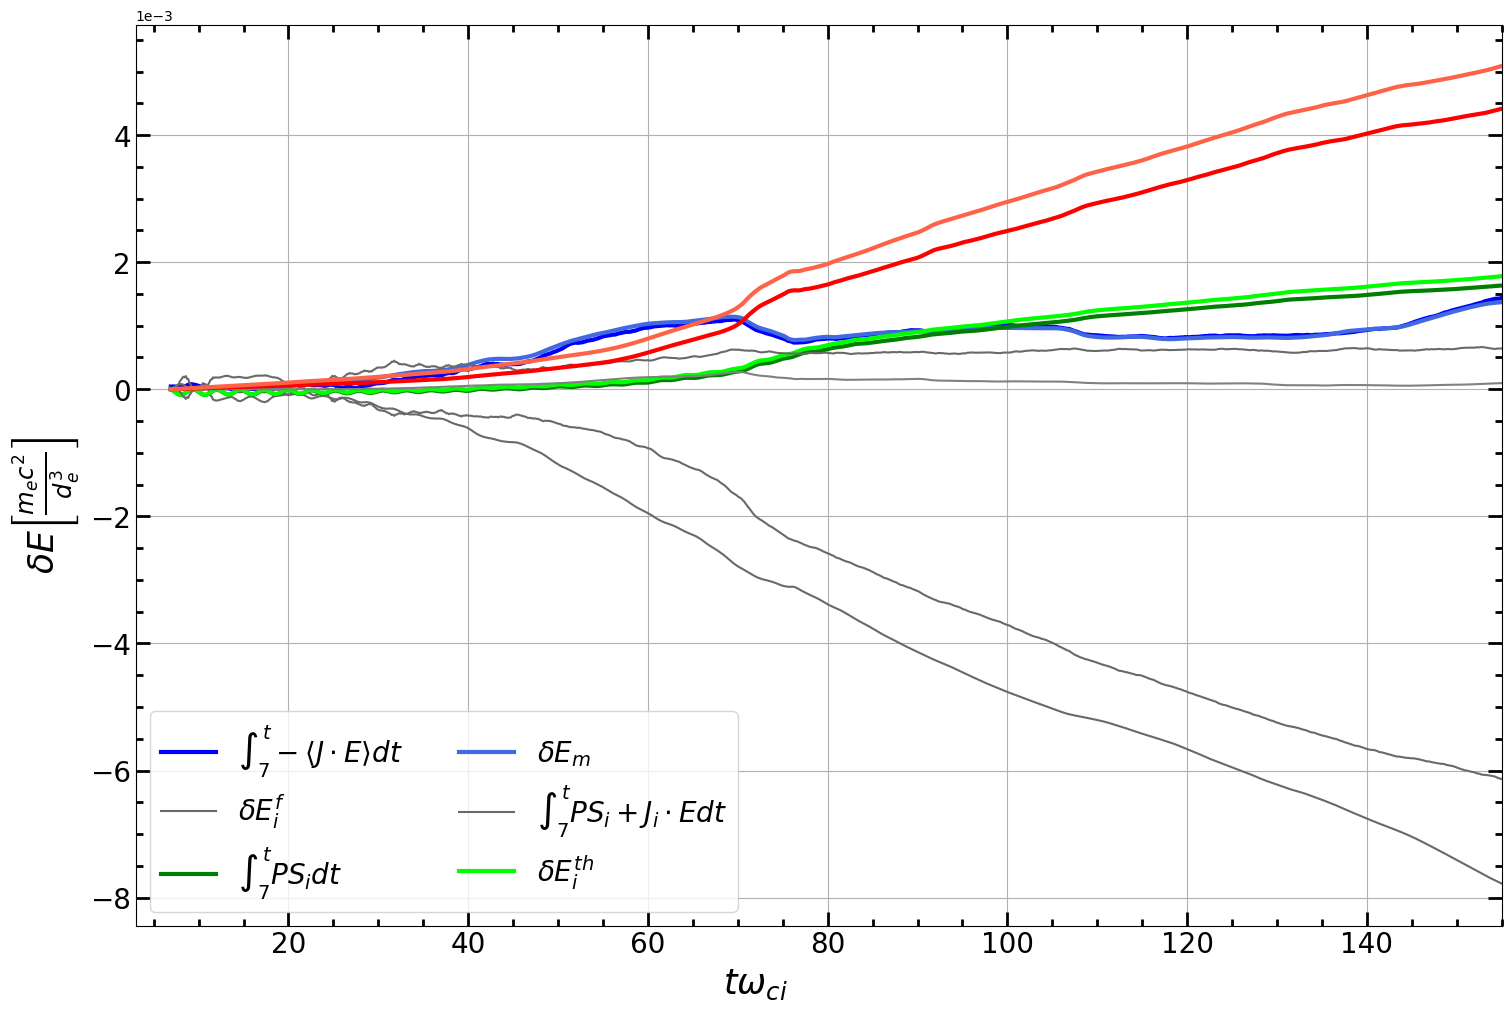

In [49]:
fig, axs = plt.subplots(1,1, figsize=(15, 10), sharex = True, layout='constrained')
import matplotlib
matplotlib.rc('font', size=10)

axs.plot(twci[n:], JE_int - JE_int[n] , linewidth = 3, color = 'blue', label = r'$\int_{'f'{time_twci}'r'}^t - \langle J \cdot E \rangle'' dt$')
axs.plot(twci[n:], (dEM + dEE)[n:] -  (dEM + dEE)[n] ,linewidth = 3, color = 'royalblue', label = r'$\delta E_m$')
axs.legend(title_fontsize = 25, loc = 'upper left', fontsize = 20)
axs.ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
axs.xaxis.set_minor_locator(AutoMinorLocator())
axs.yaxis.set_minor_locator(AutoMinorLocator())
axs.tick_params(which='both', width=2, labelsize = 20, right = True, direction = 'in')
axs.tick_params(which='major', length=10, top = True, right =True)
axs.tick_params(which='minor', length=5 , top = True, right =True)
axs.grid()

sp = 'ion'
axs.plot(twci[n:], dEfi[n:],  color = 'dimgray', label = r'$\delta E^{f}_i$')
axs.plot(twci[n:], psi_JiE,  color = 'dimgray', label = r'$\int_{'f'{time_twci}'r'}^t PS_'f'{sp[0]} + J_{sp[0]} \cdot E'' dt$')
axs.plot(twci[n:], psi_int, color = 'green', linewidth = 3,label = r'$\int_{'f'{time_twci}'r'}^t PS_'f'{sp[0]}'' dt$')
axs.plot(twci[n:], dEthi[n:],color = 'lime', linewidth = 3,label = r'$\delta E^{th}_'f'{sp[0]}''$')
axs.ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
# axs.legend(title_fontsize = 22, loc = 'upper left', fontsize = 20)
axs.xaxis.set_minor_locator(AutoMinorLocator())
axs.yaxis.set_minor_locator(AutoMinorLocator())
axs.tick_params(which='both', width=2, labelsize = 20, right = True, direction = 'in')
axs.tick_params(which='major', length=10, top = True, right =True)
axs.tick_params(which='minor', length=5 , top = True, right =True)
axs.grid()

sp = 'electron'
axs.plot(twci[n:], pse_JeE,  color = 'dimgray', label = r'$\delta E^{f}_i$')
axs.plot(twci[n:], dEfe[n:],  color = 'gray', label = r'$\delta E^{f}_e$')
axs.plot(twci[n:], pse_int + dEt[n:], color = 'red',linewidth = 3, label = r'$\int_{'f'{time_twci}'r'}^t PS_'f'{sp[0]}'' dt + \delta E_T$')
axs.plot(twci[n:], dEthe[n:], color = 'tomato', linewidth = 3,label = r'$\delta E_{th}^'f'{sp[0]}''$')
axs.ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))

axs.xaxis.set_minor_locator(AutoMinorLocator())
axs.yaxis.set_minor_locator(AutoMinorLocator())
axs.tick_params(which='both', width=2, labelsize = 20, right = True, direction = 'in')
axs.tick_params(which='major', length=10, top = True, right =True)
axs.tick_params(which='minor', length=5 , top = True, right =True)
axs.grid()

axs.set_xlim(3, 155)

# reordering the labels 
handles, labels = plt.gca().get_legend_handles_labels() 
  
# specify order 
order = [0, 2, 4, 1, 3, 5] 

axs.legend([handles[i] for i in order], [labels[i] for i in order], title_fontsize = 22, loc = 'lower left', fontsize = 20, ncols = 2)

fig.supylabel(r'$\delta E \left[ \frac{m_e c^2}{d_e^3} \right] $', size = 25)
fig.supxlabel(r'$ t \omega_{ci}$', size = 25)

plt.savefig(figs + 'JE_dEM+PS_dEth.pdf', dpi = 400)

In [35]:
print((np.array(en['Et'])[-1] - en['Et'][0])/100)

5.749557446688424e-06


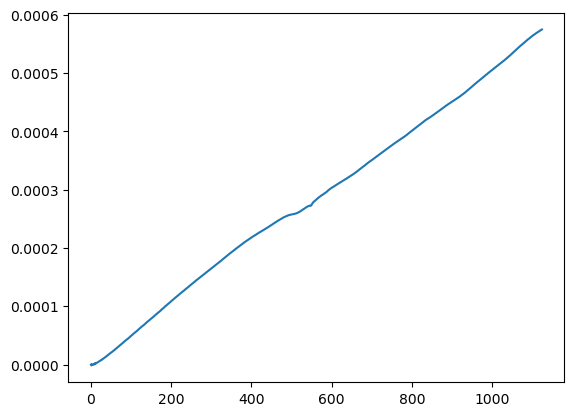

In [36]:
plt.plot(en['Et']- en['Et'][0])